Copyright 2020 Stephan Rabanser, Matthias Anderer

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

In [1]:
## Only needed when running in colab with data on your gdrive - as you can see not production but competition hack :-)

# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
import sys

package_path = 'C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001' 
sys.path.append(package_path)

###### IF NOT RUN ON COLAB YOU HAVE TO MAKE SURE THAT GLUONTS PACKAGE IS IN YOUR PATH


# Imports


In [3]:
# Make sure to select the correct MXNet Version (here we have CUDA 10.1 and mkl)
!pip install --upgrade pydantic ujson


In [4]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

In [5]:
# conda install cudatoolkit==10.1

In [6]:
# conda install cudnn

In [7]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

C:\Users\nkyam\miniforge3\lib\site-packages\ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [8]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.trainer import Trainer
from gluonts.model.n_beats import NBEATSEnsembleEstimator
from gluonts.evaluation import Evaluator


C:\Users\nkyam\miniforge3\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdaDelta is overriding existing optimizer gluonts.trainer._base.LookaheadAdaDelta
  Optimizer.opt_registry[name].__name__))
C:\Users\nkyam\miniforge3\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdaGrad is overriding existing optimizer gluonts.trainer._base.LookaheadAdaGrad
  Optimizer.opt_registry[name].__name__))
C:\Users\nkyam\miniforge3\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdam is overriding existing optimizer gluonts.trainer._base.LookaheadAdam
  Optimizer.opt_registry[name].__name__))
C:\Users\nkyam\miniforge3\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdamax is overriding existing optimizer gluonts.trainer._b

In [9]:
class M5Evaluator(Evaluator):
          
        def get_metrics_per_ts(self, time_series, forecast):
              successive_diff = np.diff(time_series.values.reshape(len(time_series)))
              successive_diff = successive_diff ** 2
              successive_diff = successive_diff[:-prediction_length]
              denom = np.mean(successive_diff)
              pred_values = forecast.samples.mean(axis=0)
              true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
              num = np.mean((pred_values - true_values)**2)
              rmsse = num / denom
              metrics = super().get_metrics_per_ts(time_series, forecast)
              metrics["RMSSE"] = rmsse
              return metrics
          
        def get_aggregate_metrics(self, metric_per_ts):
              wrmsse = metric_per_ts["RMSSE"].mean()
              agg_metric , _ = super().get_aggregate_metrics(metric_per_ts)
              agg_metric["MRMSSE"] = wrmsse
              return agg_metric, metric_per_ts

# Config

In [10]:
single_prediction_length = 28
submission_prediction_length = single_prediction_length * 2
m5_input_path="C://Users//nkyam//Desktop//m5_forecast"

SUBMISSION=True
VISUALIZE=True

VERSION=2

CALC_RESIDUALS = False

prediction_length = single_prediction_length


# Set Seeds

In [11]:
# Seed value
seed_value= 247

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set gluon seed...
mx.random.seed(seed_value)

# Read Data

In [12]:
# Load data
print('Loading data...')
sell_price = pd.read_csv('%s/sell_prices.csv' % m5_input_path)
calendar = pd.read_csv('%s/calendar.csv' % m5_input_path)
train = pd.read_csv('%s/sales_train_evaluation.csv' % m5_input_path).set_index('id')
sample_sub = pd.read_csv('%s/sample_submission.csv' % m5_input_path)


Loading data...


# Build aggregate dataset

In [13]:
# Get column groups
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
ts_cols = [col for col in train.columns if col not in cat_cols]
ts_dict = {t: int(t[2:]) for t in ts_cols}

# Describe data
print('  unique forecasts: %i' % train.shape[0])
for col in cat_cols:
    print('   N_unique %s: %i' % (col, train[col].nunique()))


  unique forecasts: 30490
   N_unique item_id: 3049
   N_unique dept_id: 7
   N_unique cat_id: 3
   N_unique store_id: 10
   N_unique state_id: 3


In [14]:
%%time
# 1. All products, all stores, all states (1 series)
all_sales = pd.DataFrame(train[ts_cols].sum()).transpose()
all_sales['id_str'] = 'all'
all_sales = all_sales[ ['id_str'] +  [c for c in all_sales if c not in ['id_str']] ]


Wall time: 117 ms


In [15]:
all_sales

,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338


In [16]:
%%time
# 2. All products by state (3 series)
state_sales = train.groupby('state_id',as_index=False)[ts_cols].sum()
state_sales['id_str'] = state_sales['state_id'] 
state_sales = state_sales[ ['id_str'] +  [c for c in state_sales if c not in ['id_str']] ]
state_sales = state_sales.drop(['state_id'],axis=1)

Wall time: 289 ms


In [17]:
state_sales

,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
1,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
2,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879


In [18]:
%%time
# 3. All products by store (10 series)
store_sales = train.groupby('store_id',as_index=False)[ts_cols].sum()
store_sales['id_str'] = store_sales['store_id'] 
store_sales = store_sales[ ['id_str'] +  [c for c in store_sales if c not in ['id_str']] ]
store_sales = store_sales.drop(['store_id'],axis=1)

Wall time: 313 ms


In [19]:
%%time
# 4. All products by category (3 series)
cat_sales = train.groupby('cat_id',as_index=False)[ts_cols].sum()
cat_sales['id_str'] = cat_sales['cat_id'] 
cat_sales = cat_sales[ ['id_str'] +  [c for c in cat_sales if c not in ['id_str']] ]
cat_sales = cat_sales.drop(['cat_id'],axis=1)


Wall time: 330 ms


In [20]:
%%time
# 5. All products by department (7 series)
dept_sales = train.groupby('dept_id',as_index=False)[ts_cols].sum()
dept_sales['id_str'] = dept_sales['dept_id'] 
dept_sales = dept_sales[ ['id_str'] +  [c for c in dept_sales if c not in ['id_str']] ]
dept_sales = dept_sales.drop(['dept_id'],axis=1)

Wall time: 303 ms


In [21]:
## TOP LEVEL aggregates + TOTAL
all_aggregates = pd.concat([all_sales,state_sales,store_sales,cat_sales,dept_sales],ignore_index=True)


# Prepare dataframe for gluon-ts


In [22]:
train_df = all_aggregates.drop(["id_str"], axis=1)
train_target_values = train_df.values

if SUBMISSION == True:
    test_target_values = [np.append(ts, np.ones(prediction_length) * np.nan) for ts in train_df.values]
else:
    test_target_values = train_target_values.copy()
    train_target_values = [ts[:-prediction_length] for ts in train_df.values]

m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(all_aggregates))]

train_ds = ListDataset([
      {
          FieldName.TARGET: target,
          FieldName.START: start
      }
      for (target, start) in zip(train_target_values,
                                          m5_dates
                                          )
  ], freq="D")

test_ds = ListDataset([
      {
          FieldName.TARGET: target,
          FieldName.START: start
      }
      for (target, start) in zip(test_target_values,
                                          m5_dates)
  ], freq="D")

C:\Users\nkyam\miniforge3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [23]:
num_signals = len(train_df)

In [24]:
next(iter(train_ds))

C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\dataset\common.py:348: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\dataset\common.py:351: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\dataset\common.py:353: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\dataset\common.py:353: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq


{'target': array([32631., 31749., 23783., ..., 42552., 51518., 54338.], dtype=float32),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'source': SourceContext(source='list_data', row=0)}

# Define Estimators and train on aggregates

In [28]:
if True:

  estimator = NBEATSEnsembleEstimator(
      prediction_length=prediction_length,
      #context_length=7*prediction_length,
      meta_bagging_size = 3,  # 3, ## Change back to 10 after testing??
      meta_context_length = [prediction_length * mlp for mlp in [3,5,7] ], ## Change back to (2,7) // 3,5,7
      meta_loss_function = ['sMAPE'], ## Change back to all three MAPE, MASE ...
      num_stacks = 30,
      widths= [512],
      freq="D",
      trainer=Trainer(
                    learning_rate=6e-4,
                    #clip_gradient=1.0,
                    epochs=10, #12
                    num_batches_per_epoch=100,
                    batch_size=16
                    #ctx=mx.context.gpu()
                )

  )
  

TRAINER:gluonts.trainer._base.Trainer(avg_strategy=gluonts.trainer.model_averaging.SelectNBestMean(maximize=False, metric="score", num_models=1), batch_size=16, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.0006, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08)


C:\Users\nkyam\miniforge3\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdaDelta is overriding existing optimizer gluonts.trainer._base.LookaheadAdaDelta
  Optimizer.opt_registry[name].__name__))
C:\Users\nkyam\miniforge3\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdaGrad is overriding existing optimizer gluonts.trainer._base.LookaheadAdaGrad
  Optimizer.opt_registry[name].__name__))
C:\Users\nkyam\miniforge3\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdam is overriding existing optimizer gluonts.trainer._base.LookaheadAdam
  Optimizer.opt_registry[name].__name__))
C:\Users\nkyam\miniforge3\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdamax is overriding existing optimizer gluonts.trainer._b

In [29]:
import time

from datetime import datetime

In [30]:
print(time.time())
print("Current Time =", datetime.now().strftime("%H:%M:%S") )
if SUBMISSION:
  predictor = estimator.train(train_ds)
else:
  predictor = estimator.train(train_ds,test_ds)
print(time.time())
print("Current Time =", datetime.now().strftime("%H:%M:%S") )

1665460744.130973
Current Time = 23:59:04
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:57: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return ts + offset * ts.freq
100%|█████████████████████████████████████████████| 100/100 [00:14<00:00,  6.70it/s, epoch=10/10, avg_epoch_loss=0.352]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|█████████████████████████████████████████████| 100/100 [00:15<00:00,  6.55it/s, epoch=10/10, avg_epoch_loss=0.348]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|█████████████████████████████████████████████| 100/100 [00:14<00:00,  6.78it/s, epoch=10/10, avg_epoch_loss=0.355]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|█████████████████████████████████████████████| 100/100 [00:15<00:00,  6.51it/s, epoch=10/10, avg_epoch_loss=0.357]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|█████████████████████████████████████████████| 100/100 [00:15<00:00,  6.53it/s, epoch=10/10, avg_epoch_loss=0.351]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|█████████████████████████████████████████████| 100/100 [00:15<00:00,  6.51it/s, epoch=10/10, avg_epoch_loss=0.357]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|██████████████████████████████████████████████| 100/100 [00:15<00:00,  6.45it/s, epoch=10/10, avg_epoch_loss=0.36]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|█████████████████████████████████████████████| 100/100 [00:15<00:00,  6.44it/s, epoch=10/10, avg_epoch_loss=0.363]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|█████████████████████████████████████████████| 100/100 [00:15<00:00,  6.43it/s, epoch=10/10, avg_epoch_loss=0.361]


1665462137.675431
Current Time = 00:22:17


# Analyze forcasts - Errors and Visual inspection


In [31]:
  forecast_it, ts_it = make_evaluation_predictions(
      dataset=test_ds,
      predictor=predictor,
      num_samples=100
  )

  print("Obtaining time series conditioning values ...")
  tss = list(tqdm(ts_it, total=len(test_ds)))
  print("Obtaining time series predictions ...")
  forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


  0%|          | 0/24 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/24 [00:00<?, ?it/s]

C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\transform\split.py:57: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return ts + offset * ts.freq
C://Users//nkyam//Desktop//m5_forecast//gluonts-20200710T072218Z-001\gluonts\model\n_beats\_ensemble.py:199: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq=start_date.freqstr,


In [32]:
if not SUBMISSION:
      evaluator = M5Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
      agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
      print(json.dumps(agg_metrics, indent=4))

# Visualize forecasts

In [33]:
num_series = len(all_aggregates)

Plotting time series predictions ...


  0%|          | 0/24 [00:00<?, ?it/s]

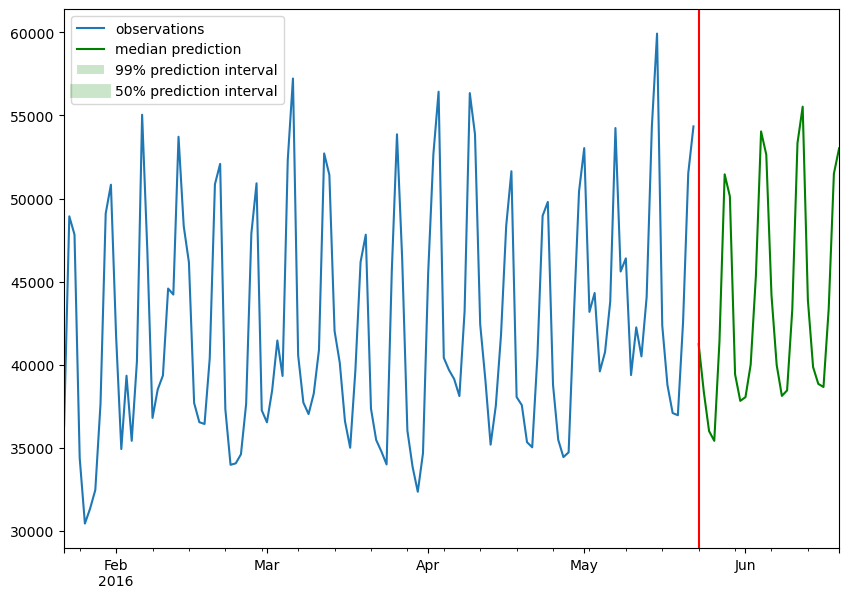

<Figure size 640x480 with 0 Axes>

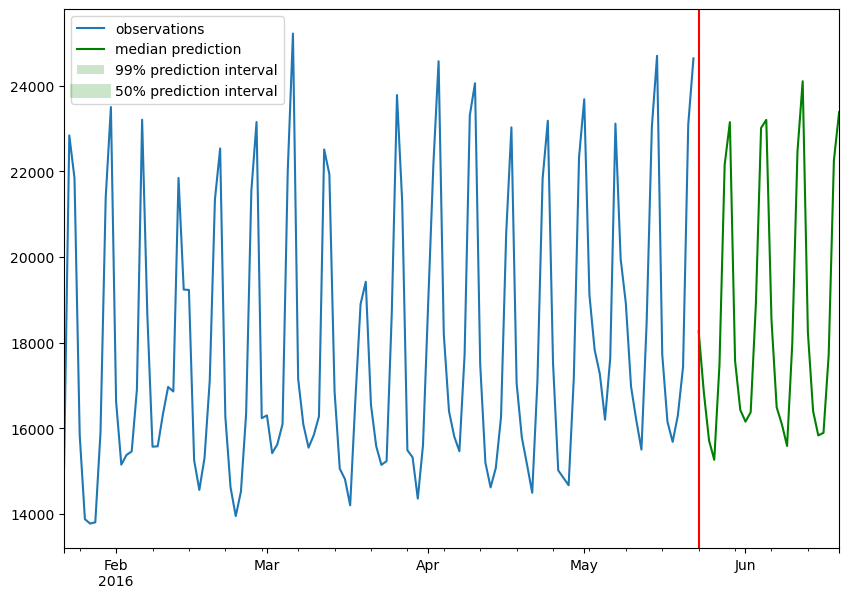

<Figure size 640x480 with 0 Axes>

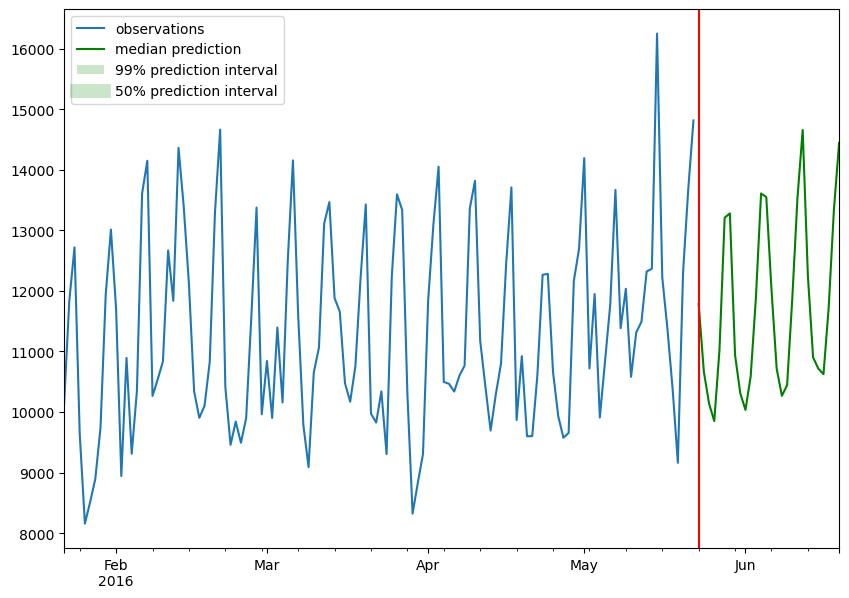

<Figure size 640x480 with 0 Axes>

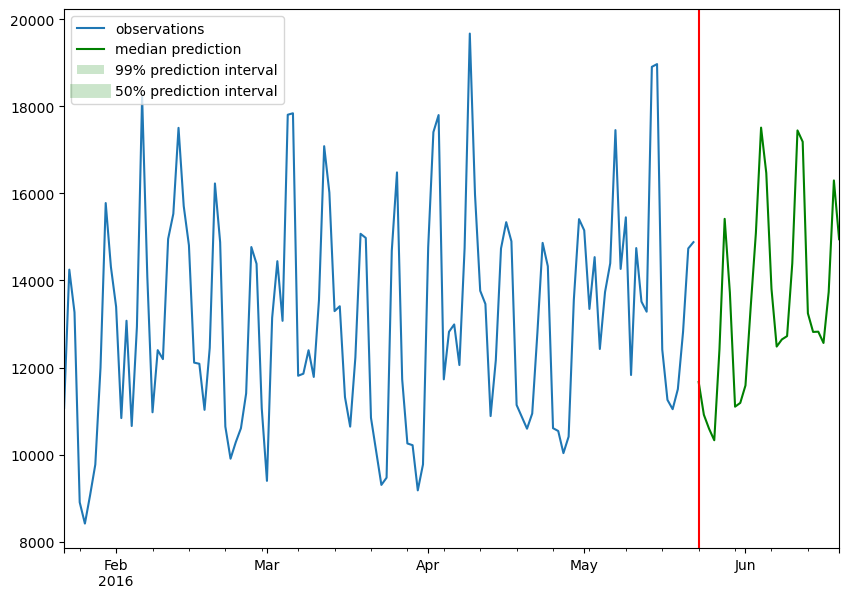

<Figure size 640x480 with 0 Axes>

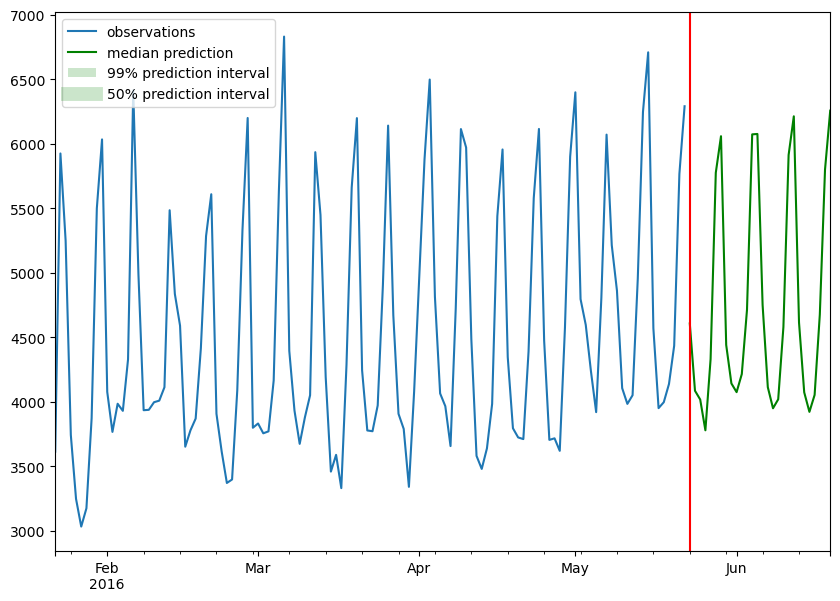

<Figure size 640x480 with 0 Axes>

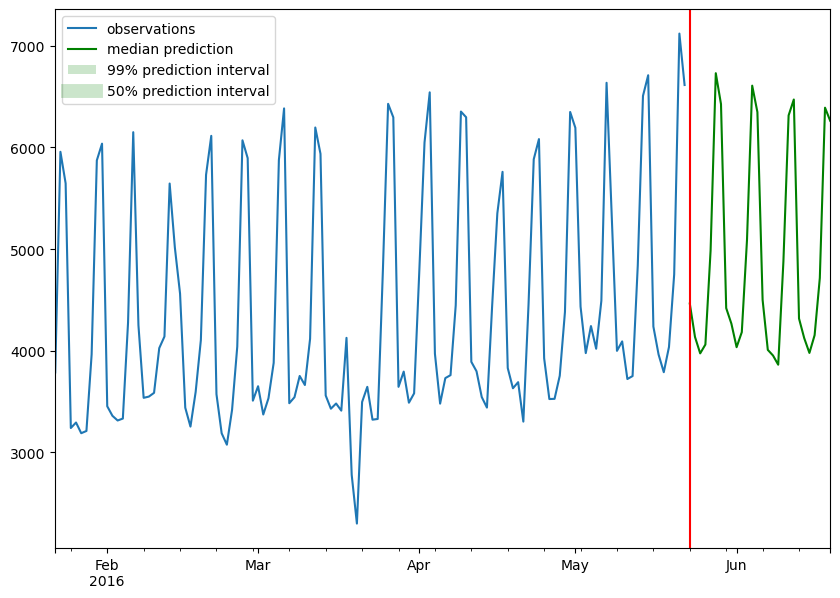

<Figure size 640x480 with 0 Axes>

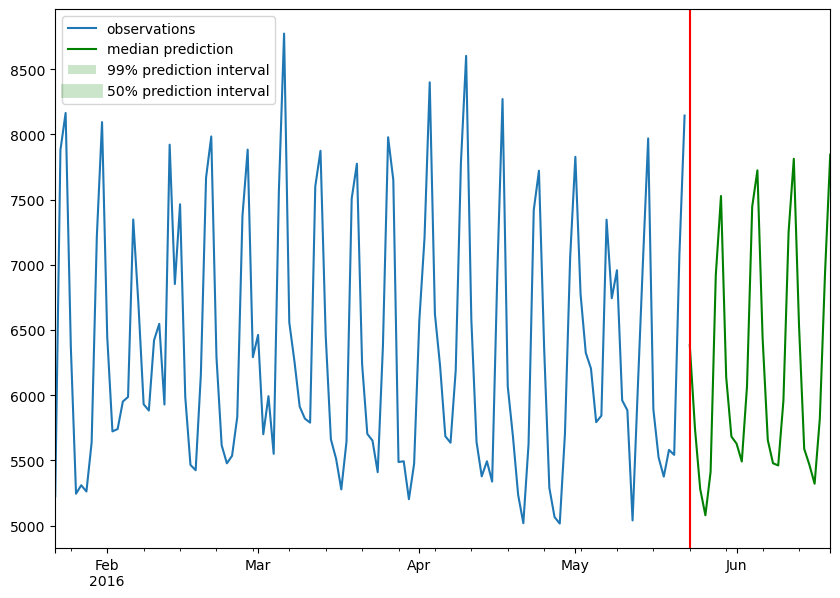

<Figure size 640x480 with 0 Axes>

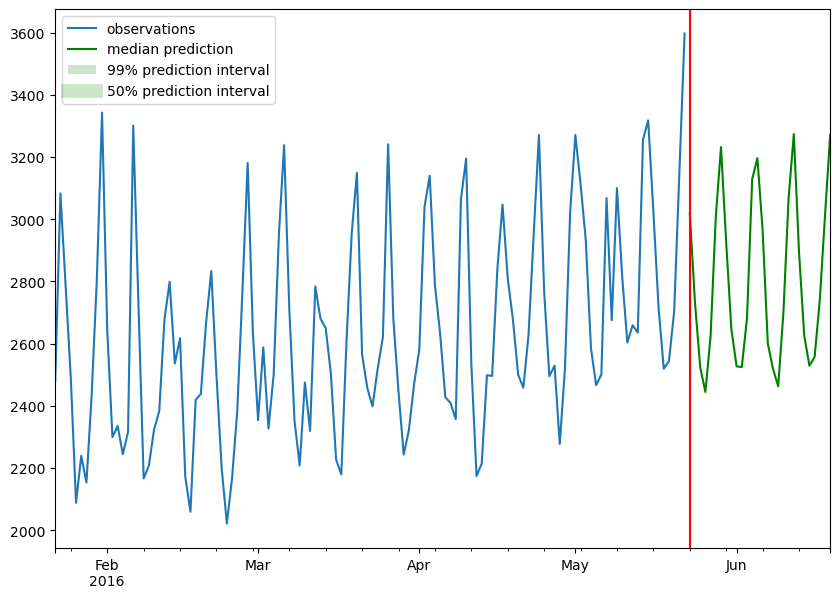

<Figure size 640x480 with 0 Axes>

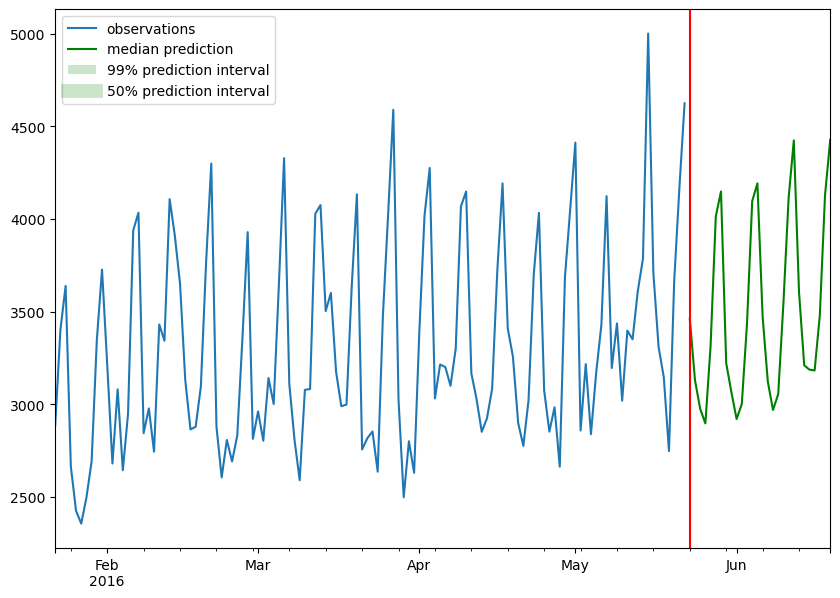

<Figure size 640x480 with 0 Axes>

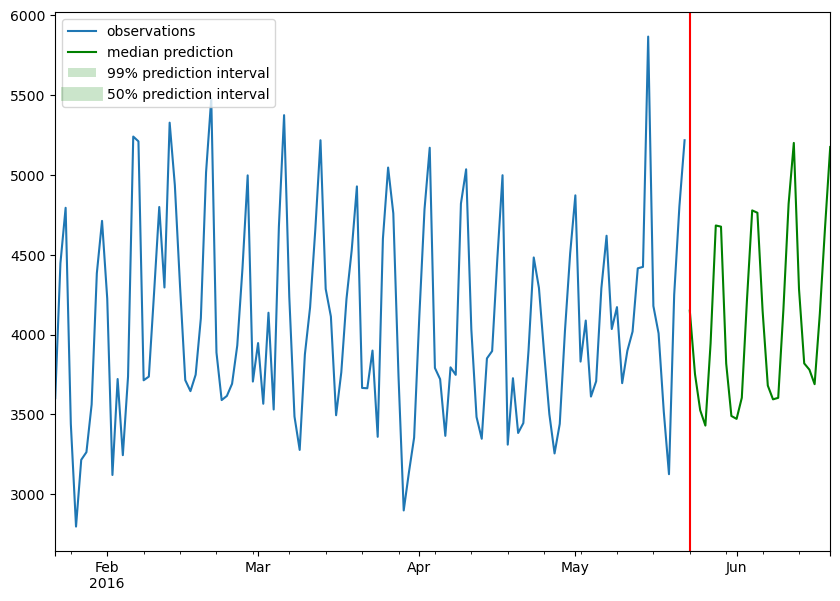

<Figure size 640x480 with 0 Axes>

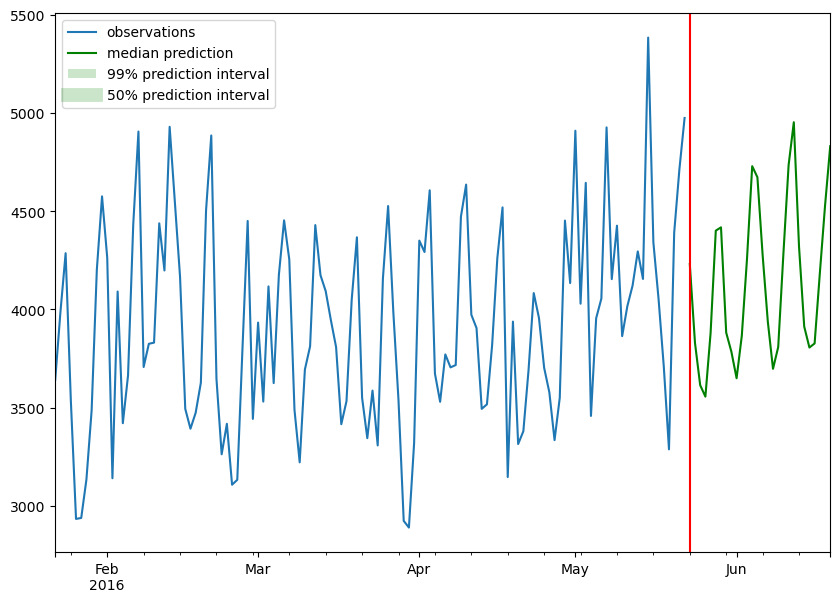

<Figure size 640x480 with 0 Axes>

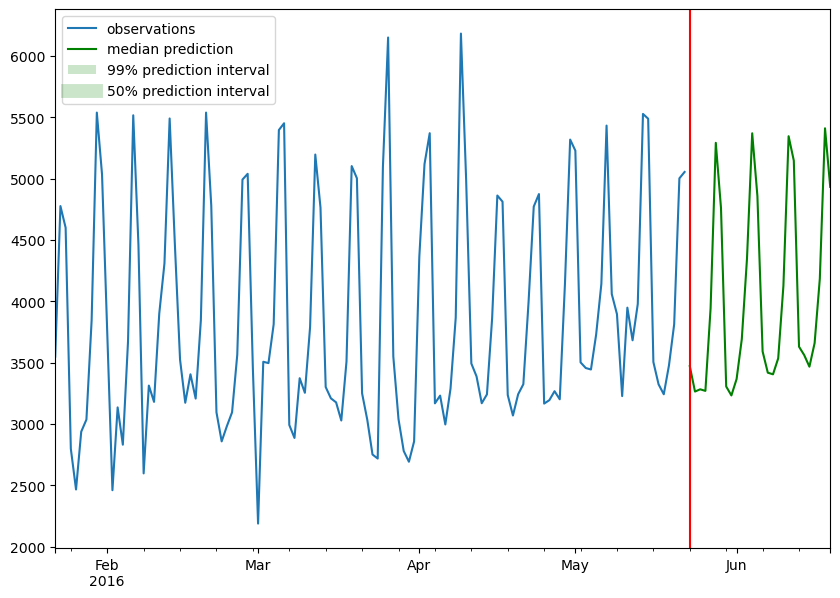

<Figure size 640x480 with 0 Axes>

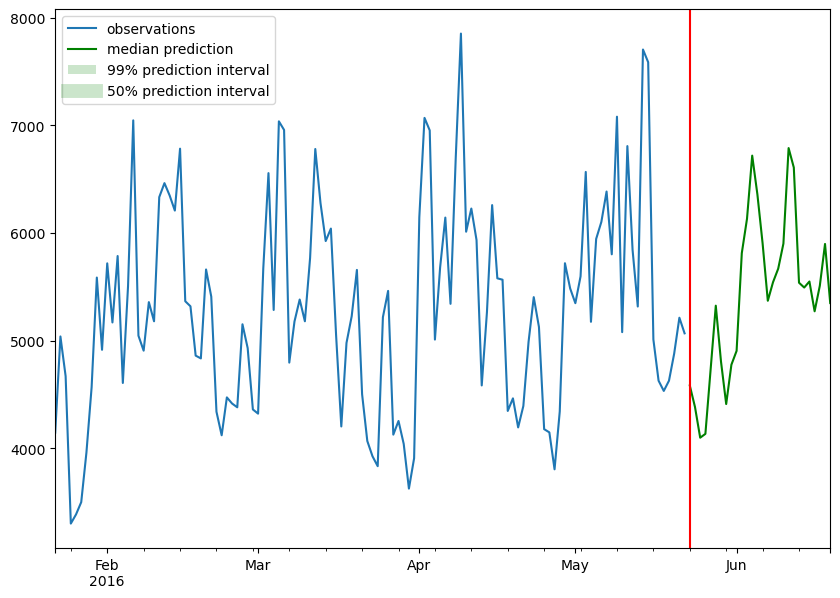

<Figure size 640x480 with 0 Axes>

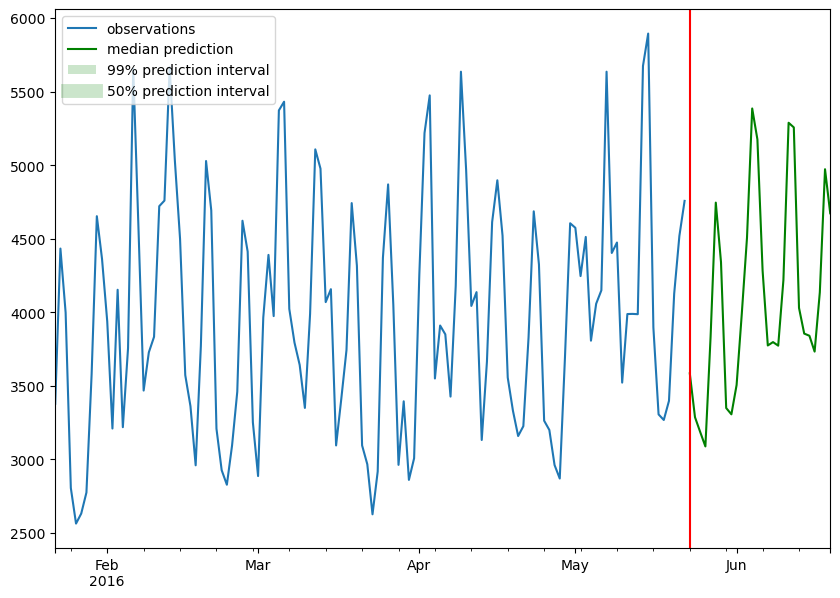

<Figure size 640x480 with 0 Axes>

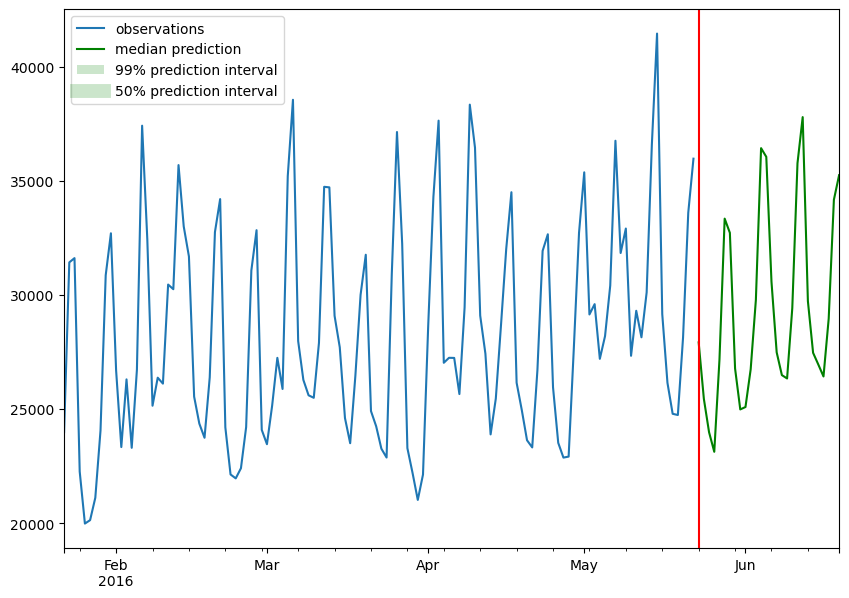

<Figure size 640x480 with 0 Axes>

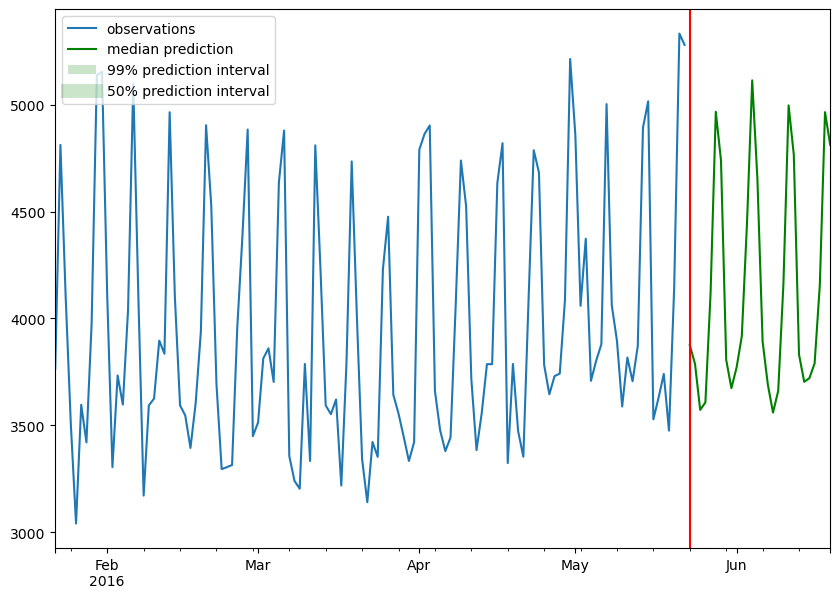

<Figure size 640x480 with 0 Axes>

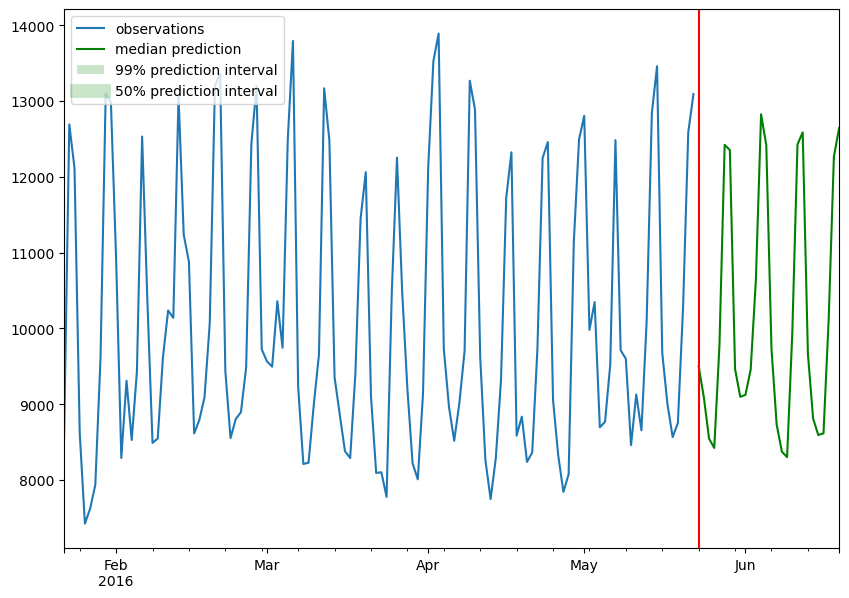

<Figure size 640x480 with 0 Axes>

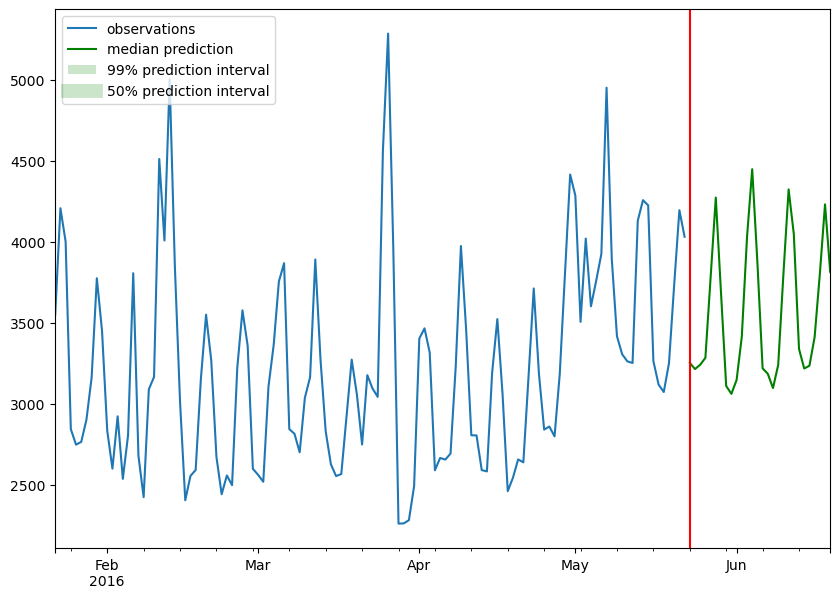

<Figure size 640x480 with 0 Axes>

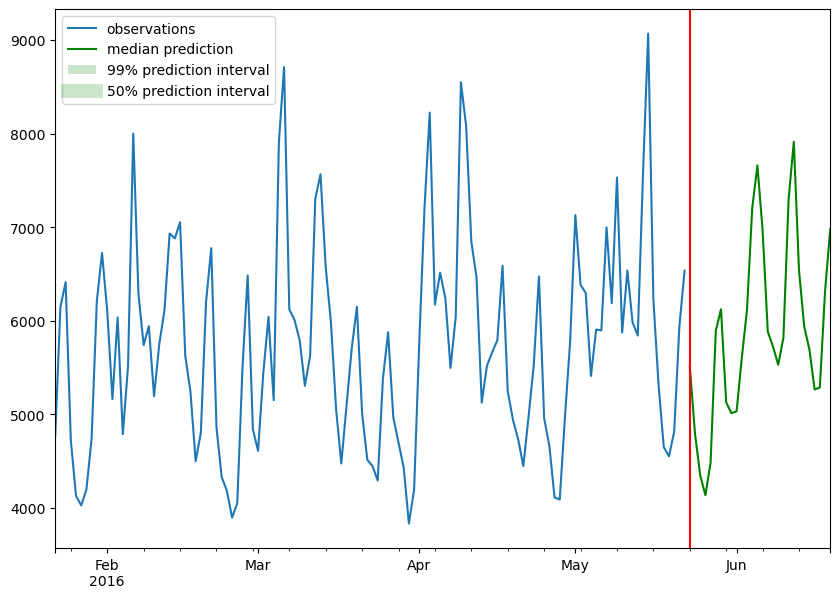

<Figure size 640x480 with 0 Axes>

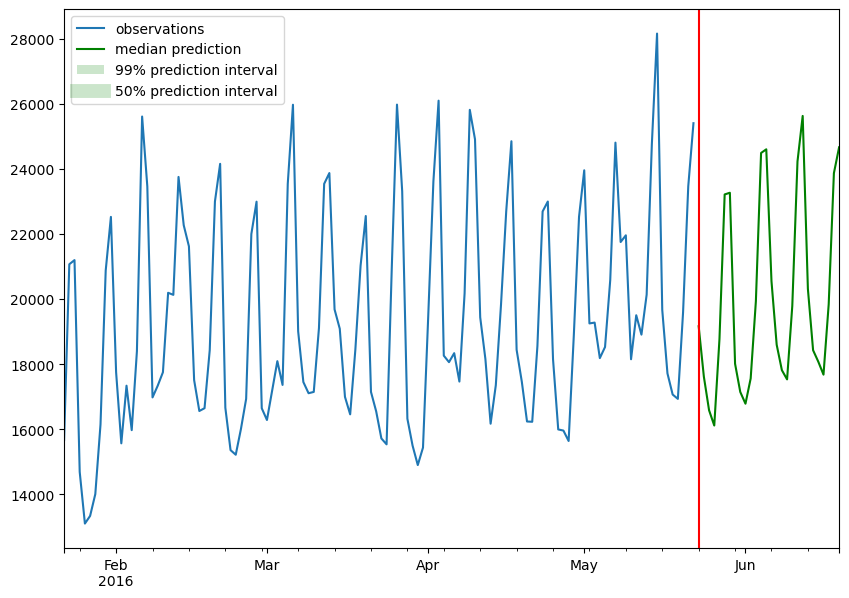

<Figure size 640x480 with 0 Axes>

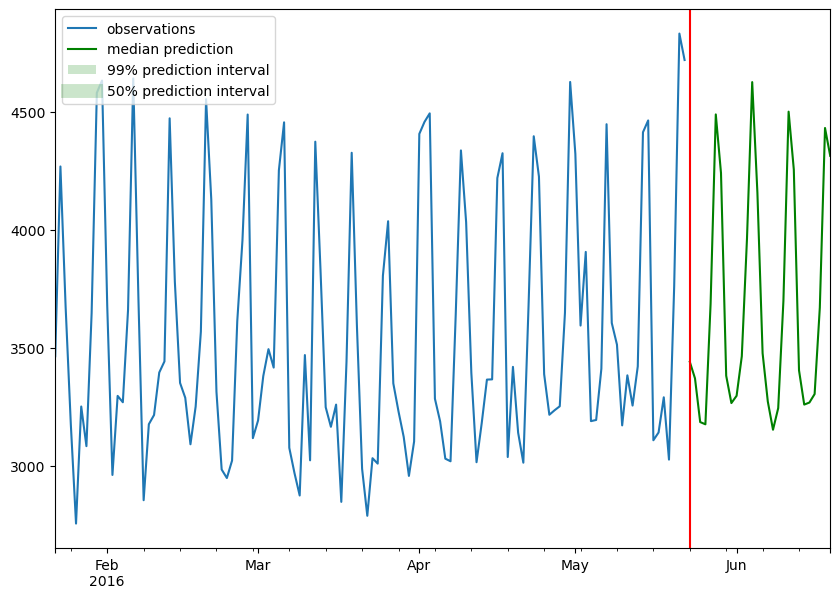

<Figure size 640x480 with 0 Axes>

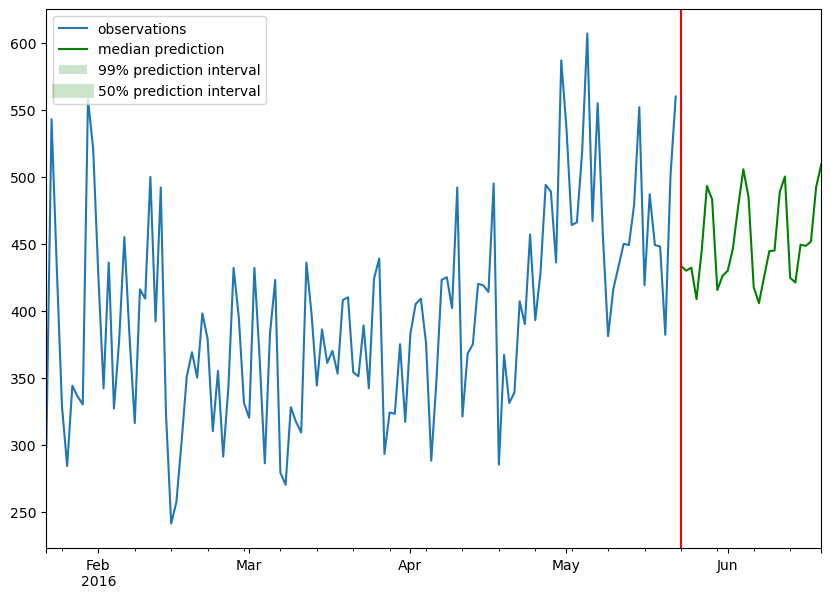

<Figure size 640x480 with 0 Axes>

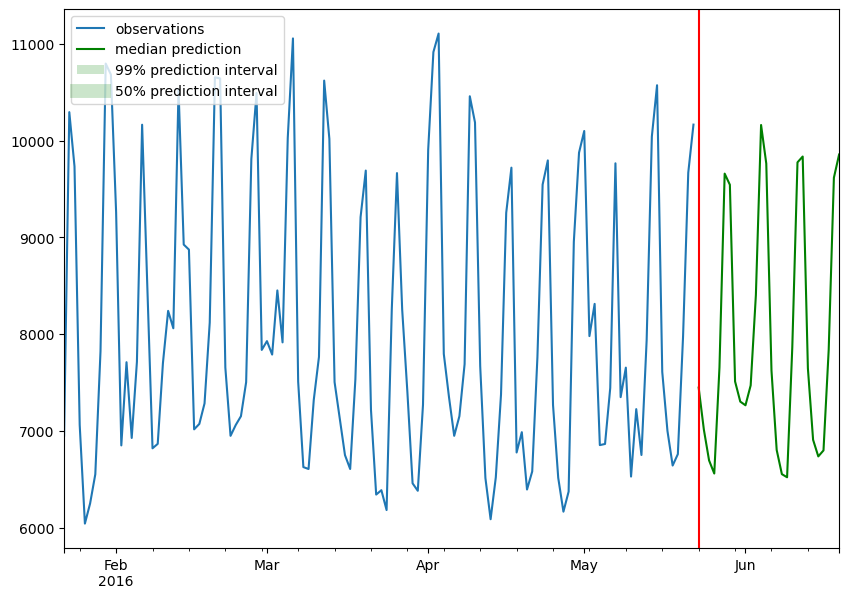

<Figure size 640x480 with 0 Axes>

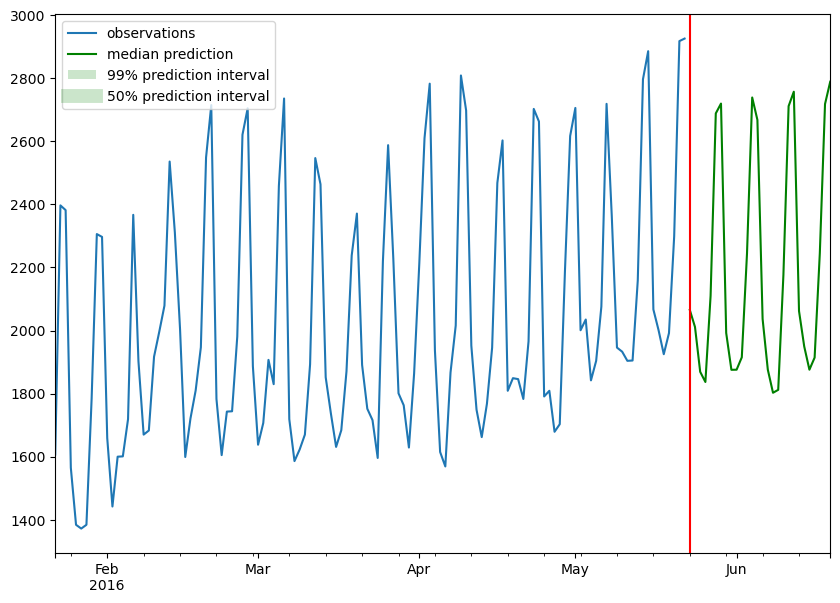

<Figure size 640x480 with 0 Axes>

In [34]:
if VISUALIZE:
  
  plot_log_path = "./plots/"
  directory = os.path.dirname(plot_log_path)
  if not os.path.exists(directory):
      os.makedirs(directory)
      
  def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
      plot_length = 150
      prediction_intervals = (50, 99)
      legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

      _, ax = plt.subplots(1, 1, figsize=(10, 7))
      ts_entry[-plot_length:].plot(ax=ax)
      forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
      ax.axvline(ts_entry.index[-prediction_length], color='r')
      plt.legend(legend, loc="upper left")
      if inline:
          plt.show()
          plt.clf()
      else:
          plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
          plt.close()

  print("Plotting time series predictions ...")
  for i in tqdm(range(num_series)):
      ts_entry = tss[i]
      forecast_entry = forecasts[i]
      plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)


# Predict and save forecast


In [35]:
forecasts_acc = np.zeros((len(forecasts), prediction_length))

for i in range(len(forecasts)):
    forecasts_acc[i] = forecasts[i].samples

columns = []
for i in range(1,(forecasts_acc.shape[1]+1)):
    columns.append("F"+str(i))
forecasts_acc_df = pd.DataFrame(data=forecasts_acc, columns=columns)

In [36]:
forecasts_acc_df = pd.concat([all_aggregates['id_str'],forecasts_acc_df],axis=1)

In [37]:
forecasts_acc_df

,id_str,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,all,41237.519531,38342.976562,36011.453125,35423.843750,41405.246094,51453.507812,50132.156250,39426.488281,37827.398438,...,43321.523438,53338.691406,55522.648438,43886.843750,39861.308594,38849.820312,38661.667969,43353.519531,51492.457031,53021.152344
1,CA,18263.433594,16829.541016,15708.728516,15259.213867,17480.603516,22156.259766,23152.783203,17572.425781,16426.679688,...,17983.609375,22473.140625,24109.917969,18237.666016,16399.875000,15828.355469,15890.291016,17714.462891,22258.351562,23385.380859
2,TX,11782.670898,10665.177734,10138.835938,9850.862305,11023.905273,13209.011719,13279.973633,10939.719727,10311.189453,...,11872.701172,13539.925781,14657.096680,12248.060547,10902.710938,10717.397461,10624.944336,11726.620117,13335.938477,14443.225586
3,WI,11667.163086,10914.969727,10593.803711,10329.683594,12422.034180,15414.328125,13721.627930,11100.828125,11187.612305,...,14393.484375,17445.203125,17184.701172,13245.059570,12817.213867,12822.989258,12563.723633,13735.892578,16296.083984,14946.267578
4,CA_1,4605.233887,4083.763428,4016.072998,3777.304932,4329.090332,5773.711426,6056.759766,4438.887207,4140.538086,...,4577.880371,5911.046875,6211.045410,4612.964844,4071.443359,3920.188232,4051.409180,4674.474609,5798.345703,6255.020020
5,CA_2,4464.213867,4136.114746,3974.278076,4061.011230,4985.875488,6730.222168,6426.489258,4419.497559,4266.367676,...,4878.821289,6315.105957,6471.647461,4317.037598,4124.223145,3978.595215,4153.266113,4716.256836,6391.107422,6261.728027
6,CA_3,6383.573242,5742.471191,5280.581543,5078.595703,5411.608887,6920.271484,7527.295410,6137.828125,5682.660645,...,5956.617188,7253.427734,7812.686523,6535.488770,5587.930664,5464.998047,5320.574219,5820.420410,6934.214355,7844.755859
7,CA_4,3018.389404,2731.262939,2523.932617,2444.430420,2623.679199,3007.607666,3231.955322,2925.234619,2644.835449,...,2699.137695,3068.315674,3274.339844,2894.830078,2626.065430,2528.617676,2556.754639,2741.435791,3012.553955,3272.687744
8,TX_1,3460.826904,3130.535400,2975.420654,2897.317871,3316.154541,4013.888428,4148.325195,3222.571289,3065.478271,...,3544.824463,4112.944336,4423.617676,3605.933350,3210.696045,3187.359863,3182.802734,3480.910156,4127.705078,4426.998535
9,TX_2,4150.050293,3752.877441,3526.619873,3430.271973,3945.304199,4683.205566,4675.945801,3818.821289,3490.482422,...,4157.830566,4818.966797,5200.174805,4284.427246,3819.637939,3780.352051,3689.541504,4129.916016,4668.497559,5174.852539


In [38]:
forecasts_acc_df.to_csv('{}nbeats_level_predictions/nbeats_toplvl_forecasts{}.csv'.format(m5_input_path, VERSION), index=False)